In [1]:
import os
from numpy import *
import operator
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,
import pandas as pd
from sklearn.neighbors import kneighbors_graph,NearestNeighbors
from sklearn import datasets
import random as rd

from sklearn.metrics import pairwise,fowlkes_mallows_score,mutual_info_score,adjusted_mutual_info_score,adjusted_rand_score
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [608]:
from sklearn.cluster import estimate_bandwidth,get_bin_seeds

In [6]:
import sys
sys.path.append("..")
from Mytools import DensityPeakClustering

In [179]:
def DP_score3(data,target,n_cluster=3):
    #dp_range=linspace(0.005,0.0150,10
    dp_range=linspace(0.01,0.80,5)
    score_3=zeros((dp_range.shape[0],3))
    for k,i in enumerate(dp_range):
        bandwidth=estimate_bandwidth(data,quantile=i,n_jobs=-1)
        dpc_mat=DensityPeakClustering.dpcluster(data, bandwidth=bandwidth, clusterNumber=n_cluster, γ=0, plot=False)
        score_3[k,0]=adjusted_rand_score(target,dpc_mat[:,0])
        score_3[k,1]=fowlkes_mallows_score(target,dpc_mat[:,0])
        score_3[k,2]=adjusted_mutual_info_score(target,dpc_mat[:,0])
        
    max_ari_index=argmax(score_3[:,0])
    print('DPC Optimal bandwidth:',estimate_bandwidth(data,quantile=dp_range[max_ari_index],n_jobs=-1))
    ARIscore=score_3[max_ari_index,0]
    FMIscore=score_3[max_ari_index,1]
    AMIscore=score_3[max_ari_index,2]
    print('maxAri:%f,maxFmi:%f,maxAmi:%f'%(ARIscore,FMIscore,AMIscore)) 
      
        
    return score_3[max_ari_index,:]


def DPCtest(data,target):
    n_cluster=unique(target).shape[0]
    scores_3=DP_score3(data,target,n_cluster=n_cluster)
    ARI=['DensityPeaks',scores_3[0],'ARI']
    FMI=['DensityPeaks',scores_3[1],'FMI']
    AMI=['DensityPeaks',scores_3[2],'AMI']
    results=[ARI,FMI,AMI]
    df=pd.DataFrame(results,columns=['Algorithm','score','Criterion'])
    return df

# Hierarchical/Agg

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [13]:
def AggScore3(data,target):
    n_clusters=len(pd.unique(target))
    linktypes=['ward', 'average','single' ]#,'complete'
    m=len(linktypes)
    s3=zeros((m,4))
    for i,lt in enumerate(linktypes):
        start=time.time()
        Agg=AgglomerativeClustering(n_clusters=n_clusters,linkage=lt,)
        labels=Agg.fit_predict(data)
        runtime=time.time()-start
        s3[i,0]=adjusted_rand_score(target,labels)
        s3[i,1]=fowlkes_mallows_score(target,labels)  
        s3[i,2]=adjusted_mutual_info_score(target,labels)  
        s3[i,3]=runtime
    return s3

def Aggtest(data,target):
    scores_3=AggScore3(data,target)
    linktypes=['ward', 'average', 'single']#, 'complete'
    critera=['ARI','FMI','AMI','RunTime']
    lp4=[]
    for i,lt in enumerate(linktypes):
        for j,cri in enumerate(critera):
            list1=[lt,cri,scores_3[i,j],]
            lp4.append(list1)
            
    df=pd.DataFrame(lp4,columns=['Algorithm','Criterion','Score'])
    return df                   
                   

# GMM

In [595]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture import BayesianGaussianMixture
def GMMtest(data,target,n_init=1,random_state=0):
    n_clusters=len(pd.unique(target))
    start_model1=time.time()
    model1=GMM(n_components=n_clusters, covariance_type='spherical',n_init=n_init,random_state=random_state)#BayesianGaussianMixture
    labels1=model1.fit_predict(data)
    end_model1=time.time()
    
    runtime_model1=end_model1-start_model1
    
    s1=adjusted_rand_score(target,labels1)
    s2=fowlkes_mallows_score(target,labels1)  
    s3=adjusted_mutual_info_score(target,labels1)  

   
    model2=GMM(n_components=n_clusters, covariance_type='diag',n_init=n_init,random_state=random_state)
    labels2=model2.fit_predict(data)
    end_model2=time.time()
    runtime_model2=end_model2-end_model1
    
    s4=adjusted_rand_score(target,labels2)
    s5=fowlkes_mallows_score(target,labels2)  
    s6=adjusted_mutual_info_score(target,labels2)  
    
    model3=GMM(n_components=n_clusters, covariance_type='full',n_init=n_init,random_state=random_state)
    labels3=model3.fit_predict(data)
    end_model3=time.time()
    runtime_model3=end_model3-end_model2
    
    s7=adjusted_rand_score(target,labels3)
    s8=fowlkes_mallows_score(target,labels3)  
    s9=adjusted_mutual_info_score(target,labels3) 
    
    
    criteria=['ARI','FMI','AMI']
    
    ARI=['EM(spherical)','ARI',s1]
    FMI=['EM(spherical)','FMI',s2]
    AMI=['EM(spherical)','AMI',s3]
    RunTime=['EM(spherical)','RunTime',runtime_model1]
    
    ARI2=['EM(diag)','ARI',s4]
    FMI2=['EM(diag)','FMI',s5]
    AMI2=['EM(diag)','AMI',s6]
    RunTime2=['EM(diag)','RunTime',runtime_model2]
    
    ARI3=['EM(full)','ARI',s7]
    FMI3=['EM(full)','FMI',s8]
    AMI3=['EM(full)','AMI',s9]
    RunTime3=['EM(full)','RunTime',runtime_model3]
    
    
    results=[ARI,FMI,AMI,RunTime,ARI2,FMI2,AMI2,RunTime2,ARI3,FMI3,AMI3,RunTime3]
    df=pd.DataFrame(results,columns=['Algorithm','Criterion','Score'])
    runtime=[runtime_model1,runtime_model2,runtime_model3]
    return df

# RunTimeTest

In [592]:
def runtime_test_Gmm(data, target,Prange=props):
    props=Prange
    n=props.shape[0]
    times_3=zeros((3,n))
    
    for i,p in enumerate(props):
        print(i,p)
        X_train, X_test, y_train, y_test = train_test_split( data, target, train_size =p,stratify=target, random_state=0)
        r=GMMtest( X_train,y_train)
        for k in range(3):
            runtime=r.Score[r.Criterion=='RunTime'].values[k]
            times_3[k,i]=runtime
    linktypes=['spherical', 'diag','full' ]
    
    for i in range(3):
        plt.plot(props,times_3[i],label=linktypes[i])
    plt.legend()
        
    return times_3

In [135]:
def runtime_test_Agg(data, target,Prange):
    props=Prange
    n=props.shape[0]
    times_3=zeros((3,n))
    
    for i,p in enumerate(props):
        print(i,p)
        X_train, X_test, y_train, y_test = train_test_split( data, target, train_size =p,stratify=target, random_state=0)
        r=Aggtest( X_train,y_train)
        for k in range(3):
            runtime=r.Score[r.Criterion=='RunTime'].values[k]
            times_3[k,i]=runtime
    linktypes=['ward', 'average','single' ]
    
    for i in range(3):
        plt.plot(props,times_3[i],label=linktypes[i])
    plt.legend()
        
    return times_3
        

In [ ]:
def runtime_test_NGMM(data, target,Prange):
    props=Prange
    n=props.shape[0]
    times_3=zeros((3,n))
    stage=['Global Approximation','Structure Extraction','Complete Algorithm'] 
    for i,p in enumerate(props):
        print(i,p)
        X_train, X_test, y_train, y_test = train_test_split( data, target, train_size =p,stratify=target, random_state=0)
        Time_3=NestedGaussianMixtureclustering.RunTimeTest_NGMM_A(X_train,
                                                y_train,  
                                                targetN=None,
                                                random_state=0,
                                                covariance_type='diag',
                                               )
        for k in range(3):
            runtime=Time_3[k]
            print(stage[k])
            print('runtime',runtime)
            times_3[k,i]=runtime
    
    
    for i in range(3):
        plt.plot(props,times_3[i],label=stage[i])
    plt.legend()
        
    return times_3

# Run-time Test (using different proportional samplings of Mnist-784)

In [ ]:
MNIST=fetch_openml('mnist_784',as_frame=True)
X25=MNIST.data.values
y25=MNIST.target.values

In [432]:
X25.shape

(70000, 784)

## run-time test for our methods (two separate stages and the overall run time)

0 0.05
best t 92
break s<=0
Global Approximation
runtime 12.905794382095337
Structure Extraction
runtime 0.11088681221008301
Complete Algorithm
runtime 13.01668119430542
1 0.15000000000000002
best t 92
break s<=0
Global Approximation
runtime 56.44529461860657
Structure Extraction
runtime 0.41457533836364746
Complete Algorithm
runtime 56.859869956970215
2 0.25000000000000006
best t 92
Global Approximation
runtime 109.05053305625916
Structure Extraction
runtime 0.6513326168060303
Complete Algorithm
runtime 109.70186567306519
3 0.35000000000000003
best t 92
Global Approximation
runtime 200.52604413032532
Structure Extraction
runtime 0.8311343193054199
Complete Algorithm
runtime 201.35717844963074
4 0.45000000000000007


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


best t 92
Global Approximation
runtime 260.1378448009491
Structure Extraction
runtime 1.0579066276550293
Complete Algorithm
runtime 261.1957514286041
5 0.5500000000000002


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


best t 92
Global Approximation
runtime 347.29898738861084
Structure Extraction
runtime 1.2976751327514648
Complete Algorithm
runtime 348.5966625213623
6 0.6500000000000001


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


best t 92
break s<=0
Global Approximation
runtime 408.1168234348297
Structure Extraction
runtime 1.5744051933288574
Complete Algorithm
runtime 409.69122862815857
7 0.7500000000000002
best t 92
break s<=0
Global Approximation
runtime 487.16803526878357
Structure Extraction
runtime 1.9080631732940674
Complete Algorithm
runtime 489.07609844207764


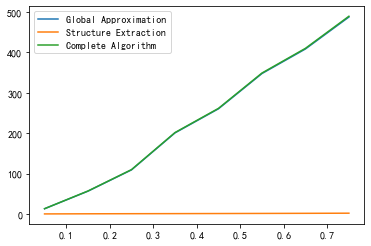

In [388]:
props=arange(0.05,0.8,0.1)
Ngmm_r_075=runtime_test_NGMM(X25, y25,Prange=props)

## run-time test for GMM using different types of covariance matrix

0 0.05
1 0.15000000000000002
2 0.25000000000000006
3 0.35000000000000003
4 0.45000000000000007
5 0.5500000000000002
6 0.6500000000000001
7 0.7500000000000002


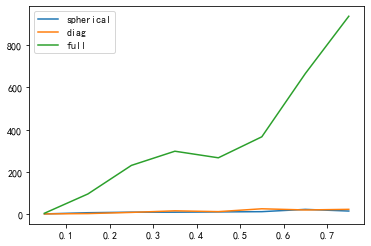

In [133]:
random.seed(0)
props=arange(0.05,0.8,0.1)
gmm_r_075_2=runtime_test_Gmm(X25,y25,Prange=props)

## run-time test for Hierarchical clustering using different similarity metrics

0 0.05
1 0.15000000000000002
2 0.25000000000000006
3 0.35000000000000003
4 0.45000000000000007
5 0.5500000000000002
6 0.6500000000000001
7 0.7500000000000002


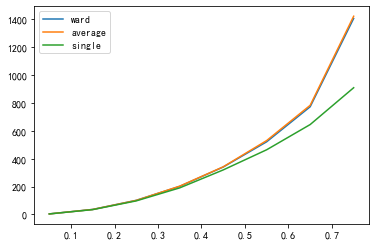

In [136]:
props=arange(0.05,0.8,0.1)
runtimes_agg_08=runtime_test_Agg(X25, y25,Prange=props)

# comprehensive comparison of run-time

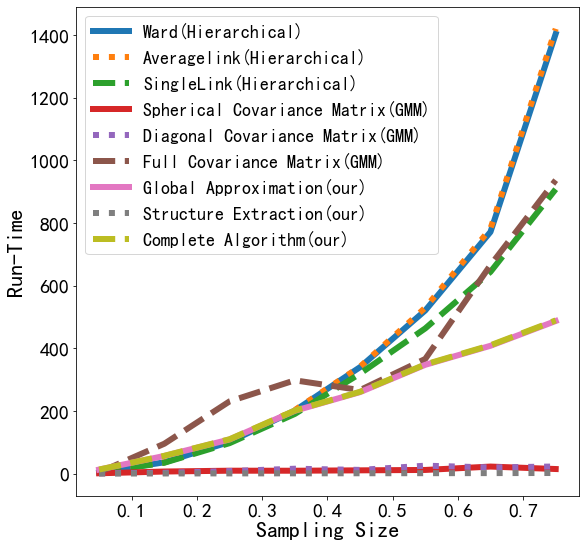

In [436]:
ThreeAlg=concatenate((runtimes_agg_08,gmm_r_075_2,Ngmm_r_075))
plt.figure(figsize=(9,9))
alg=['Ward(Hierarchical)', 'Averagelink(Hierarchical)', 'SingleLink(Hierarchical)'
     ,'Spherical Covariance Matrix(GMM)', 'Diagonal Covariance Matrix(GMM)','Full Covariance Matrix(GMM)',
     'Global Approximation(our)','Structure Extraction(our)','Complete Algorithm(our)' ]
linestyles=['-',':','--']
for i in range(9):
    index=(i)%3
    plt.plot(props,TwoAlg[i],label=alg[i],linewidth=linewidth+4,linestyle=linestyles[index])
plt.xlabel('Sampling Size',fontsize=22)
plt.ylabel('Run-Time',fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=18)

# Experiments about Performance 

In [69]:
set_printoptions(suppress=True)

In [601]:
import NestedGaussianMixtureclustering
import importlib
importlib.reload(NestedGaussianMixtureclustering)

<module 'NestedGaussianMixtureclustering' from 'C:\\Users\\Administrator\\NGMM\\NestedGaussianMixtureclustering.py'>

# Datasets

In [ ]:
ba=fetch_openml('banknote-authentication',as_frame=True)
X11=ba.data.values
y11=ba.target.values
stdBankData=StandardScaler().fit_transform(X11)
X11_norm=MinMaxScaler().fit_transform(X11)

In [440]:
si=fetch_openml('satellite_image',as_frame=True)
X22=si.data.values
y22=si.target.values

In [438]:
segment=fetch_openml('segment',as_frame=True)#semeion,vehicle,analcatdata_authorship
X31=segment.data.values
y31=segment.target.values
#y31=tools.transferTarget(y31)

In [ ]:
analcatdata=fetch_openml('analcatdata_authorship',as_frame=True)#semeion,vehicle,analcatdata_authorship
X32=analcatdata.data.values
y32=analcatdata.target.values
pd.value_counts(y32)

# Experiments for Hierarchical using different link

### Singlink method tend to yield bad solutions w.r.t ARI score. 
### As shown in the following experiments on Banknote, Satellite_image,Segment,Analcatdata_authorship 


In [182]:
r_agg_X11=Aggtest(X11,y11).pivot(index='Algorithm',columns='Criterion')
r_agg_X11

Score                              
Criterion       AMI       ARI       FMI   RunTime
Algorithm                                        
average    0.111968  0.100081  0.651494  0.031950
single    -0.000209 -0.000291  0.710560  0.014985
ward       0.003003  0.004381  0.504965  0.040957

In [441]:
r_agg_X22=Aggtest(X22,y22).pivot(index='Algorithm',columns='Criterion')
r_agg_X22

Score                              
Criterion       AMI       ARI       FMI   RunTime
Algorithm                                        
average    0.425529  0.273357  0.499754  1.515451
single     0.000596  0.000273  0.435219  0.654205
ward       0.516842  0.423383  0.543267  1.567398

In [439]:
r_agg_X31=Aggtest(X31,y31).pivot(index='Algorithm',columns='Criterion')
r_agg_X31

Score                              
Criterion       AMI       ARI       FMI   RunTime
Algorithm                                        
average    0.007849  0.000132  0.374193  0.131866
single     0.001081  0.000023  0.376191  0.060240
ward       0.487182  0.308135  0.447538  0.156840

In [183]:
r_agg_X32=Aggtest(X32,y32).pivot(index='Algorithm',columns='Criterion')
r_agg_X32

Score                              
Criterion       AMI       ARI       FMI   RunTime
Algorithm                                        
average    0.264759  0.119329  0.535121  0.024975
single     0.005261  0.000664  0.555417  0.020979
ward       0.771754  0.766962  0.838959  0.030981

## Comparison on Banknote

### GMM on banknote

In [596]:
GMMtest(X11,y11).pivot(index='Algorithm',columns='Criterion')

Score                              
Criterion           AMI       ARI       FMI   RunTime
Algorithm                                            
EM(diag)       0.018376  0.024076  0.514804  0.019980
EM(full)       0.004912  0.002790  0.513156  0.019979
EM(spherical)  0.020289  0.035305  0.553778  0.008990

### Agg on banknote

In [173]:
Aggtest(X11,y11).pivot(index='Algorithm',columns='Criterion')

Score                              
Criterion       AMI       ARI       FMI   RunTime
Algorithm                                        
average    0.111968  0.100081  0.651494  0.030968
single    -0.000209 -0.000291  0.710560  0.014980
ward       0.003003  0.004381  0.504965  0.037961

### Density peaks clustering on banknote

In [569]:
DPCtest(X11,y11)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=1.4055657478652772 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=6.212003089494423 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=8.393477431512443 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=10.600745195767097 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn

DPC Optimal bandwidth: 1.4055657478652772
maxAri:0.223736,maxFmi:0.646723,maxAmi:0.341307


,Algorithm,score,Criterion
0,DensityPeaks,0.223736,ARI
1,DensityPeaks,0.646723,FMI
2,DensityPeaks,0.341307,AMI


### Our method on banknote

In [605]:
R_NGMM_banknote=NestedGaussianMixtureclustering.NGMM(X11,
    y11,
    N=50,
    targetN=False,
    sim_threshold=0.1,
    covariance_type='diag',
    random_state=0,)
R_NGMM_banknote[1]

,AMI,ARI,FMI,RunTime
0,0.609486,0.627931,0.818197,0.882319


## Comparison on Satelliteimage

In [484]:
r_agg_satellite=Aggtest(X22,y22).pivot(index='Algorithm',columns='Criterion')
r_agg_satellite

Score                              
Criterion       AMI       ARI       FMI   RunTime
Algorithm                                        
average    0.425529  0.273357  0.499754  1.491958
single     0.000596  0.000273  0.435219  0.690093
ward       0.516842  0.423383  0.543267  1.565488

In [597]:
r_gmm_satellite=GMMtest(X22,y22,).pivot(index='Algorithm',columns='Criterion')
r_gmm_satellite

Score                              
Criterion           AMI       ARI       FMI   RunTime
Algorithm                                            
EM(diag)       0.599716  0.501046  0.593653  0.115881
EM(full)       0.553319  0.464535  0.583865  0.946033
EM(spherical)  0.585540  0.491405  0.586718  0.101882

In [570]:
DPCtest(X22,y22)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=36.4358200613815 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=87.28258827579263 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=115.2807691964505 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=150.83036685021935 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\u

DPC Optimal bandwidth: 36.4358200613815
maxAri:0.397453,maxFmi:0.566049,maxAmi:0.539533


,Algorithm,score,Criterion
0,DensityPeaks,0.397453,ARI
1,DensityPeaks,0.566049,FMI
2,DensityPeaks,0.539533,AMI


In [602]:
R_NGMM_satellite=NestedGaussianMixtureclustering.NGMM(X22,y22,
    N=140,
    targetN=False,
    sim_threshold=1,
    covariance_type='diag',
    n_init=1,
    random_state=0,)
R_NGMM_satellite[1]

,AMI,ARI,FMI,RunTime
0,0.778688,0.782497,0.836886,3.315276


## Comparison on Segment

In [561]:
r_agg_segment=Aggtest(X31,y31).pivot(index='Algorithm',columns='Criterion')
r_agg_segment

Score                              
Criterion       AMI       ARI       FMI   RunTime
Algorithm                                        
average    0.007849  0.000132  0.374193  0.138845
single     0.001081  0.000023  0.376191  0.064931
ward       0.487182  0.308135  0.447538  0.150846

In [598]:
r_gmm_segment=GMMtest(X31,y31).pivot(index='Algorithm',columns='Criterion')
r_gmm_segment

Score                              
Criterion           AMI       ARI       FMI   RunTime
Algorithm                                            
EM(diag)       0.538378  0.399515  0.499838  0.064934
EM(full)       0.599489  0.443775  0.543541  0.171825
EM(spherical)  0.479369  0.326445  0.441243  0.028969

In [571]:
DPCtest(X31,y31)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=35.691091948769156 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=118.38105566623977 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=154.94131511710444 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=188.74085761922976 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklea

DPC Optimal bandwidth: 35.691091948769156
maxAri:0.238077,maxFmi:0.503996,maxAmi:0.558404


,Algorithm,score,Criterion
0,DensityPeaks,0.238077,ARI
1,DensityPeaks,0.503996,FMI
2,DensityPeaks,0.558404,AMI


In [603]:
R_NGMM_segment=NestedGaussianMixtureclustering.NGMM(X31,y31,
    N=100,
    targetN=False,
    sim_threshold=0.1,
    covariance_type='diag',
    n_init=1,
    random_state=0,)
R_NGMM_segment[1]

,AMI,ARI,FMI,RunTime
0,0.742047,0.611497,0.681623,1.183794


## Comparison on Analcatdata_authorship

In [563]:
r_agg_authorship=Aggtest(X32,y32).pivot(index='Algorithm',columns='Criterion')
r_agg_authorship

Score                              
Criterion       AMI       ARI       FMI   RunTime
Algorithm                                        
average    0.264759  0.119329  0.535121  0.025974
single     0.005261  0.000664  0.555417  0.020979
ward       0.771754  0.766962  0.838959  0.029969

In [599]:
r_gmm_authorship=GMMtest(X32,y32).pivot(index='Algorithm',columns='Criterion')
r_gmm_authorship

Score                              
Criterion           AMI       ARI       FMI   RunTime
Algorithm                                            
EM(diag)       0.788730  0.750574  0.825377  0.018979
EM(full)       0.747685  0.726401  0.807854  0.054944
EM(spherical)  0.704146  0.684830  0.777844  0.013975

In [572]:
DPCtest(X32,y32)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=42.48079859410245 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=63.99937954429763 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=75.50018560999062 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=84.88967381404585 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\u

DPC Optimal bandwidth: 96.78401285550785
maxAri:0.502791,maxFmi:0.726823,maxAmi:0.597852


,Algorithm,score,Criterion
0,DensityPeaks,0.502791,ARI
1,DensityPeaks,0.726823,FMI
2,DensityPeaks,0.597852,AMI


In [607]:
R_NGMM_authorship=NestedGaussianMixtureclustering.NGMM(X32,
    y32,
    N=50,
    targetN=False,
    sim_threshold=0.0001,
    covariance_type='diag',
    n_init=2,
    random_state=0,)

In [606]:
R_NGMM_authorship[1]

,AMI,ARI,FMI,RunTime
0,0.975269,0.988657,0.992179,0.292687
